In [1]:
import numba
import pandas
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import IPython
import IPython.display

2023-01-30 10:05:37.340334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 10:05:39.348048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2023-01-30 10:05:39.351758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2023-01-30 10:05:39.351781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.c

## Récupération des données

In [47]:
df = pandas.read_csv("1866_2022_4.csv")
date_time = pandas.to_datetime(df.pop('Date'), format='%d/%m/%Y %H:%M:%S')
print(df)

         Valeur  Source
0         3.510       4
1         4.960       4
2         6.200       4
3         6.940       4
4         7.110       4
...         ...     ...
1261702   6.125       4
1261703   5.278       4
1261704   4.244       4
1261705   3.230       4
1261706   2.423       4

[1261707 rows x 2 columns]


In [48]:
datas = df["Valeur"].values[:300_000]
datas = datas.reshape([len(datas),1])
print(datas.shape)
print(datas)

(300000, 1)
[[3.51]
 [4.96]
 [6.2 ]
 ...
 [6.45]
 [6.34]
 [5.54]]


In [49]:
n = len(datas)
train = datas[:int(0.8*n),:]
test = datas[int(0.8*n):, :]
train

array([[3.51],
       [4.96],
       [6.2 ],
       ...,
       [3.11],
       [3.27],
       [3.52]])

### Longueur d'entrée et de sortie

In [58]:
input_length = 96
output_length = 12
batch_size = 512

### Fonction de fenetrage

In [59]:
def split(array):
    inputs = array[:,0:input_length, :]
    outputs = array[:,input_length:input_length+output_length, :]
    
    inputs.set_shape([None,input_length, None])
    outputs.set_shape([None, output_length, None])
    return inputs,outputs

### Création des datasets

In [60]:
train = np.array(train, dtype=np.float32)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
  data=train,
  targets=None,
  sequence_length=output_length+input_length,
  sequence_stride=1,
  shuffle=True,
  batch_size=batch_size)

train_ds = train_ds.map(split)
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None))>

In [61]:
test = np.array(test, dtype=np.float32)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
  data=test,
  targets=None,
  sequence_length=output_length+input_length,
  sequence_stride=1,
  shuffle=True,
  batch_size=batch_size)

test_ds = test_ds.map(split)

### Création du modèle

In [62]:
multi_conv_model = tf.keras.Sequential([
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(3), input_shape = (input_length, 1)),
    tf.keras.layers.Flatten(),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(output_length,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([output_length, 1])
])
multi_conv_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 94, 32)            128       
                                                                 
 flatten_4 (Flatten)         (None, 3008)              0         
                                                                 
 dense_10 (Dense)            (None, 12)                36108     
                                                                 
 reshape_10 (Reshape)        (None, 12, 1)             0         
                                                                 
Total params: 36,236
Trainable params: 36,236
Non-trainable params: 0
_________________________________________________________________


In [63]:
multi_lstm_model =  tf.keras.Sequential([
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.LSTM(64, activation='tanh', input_shape = (input_length, 1)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(output_length, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([output_length, 1])
])
multi_lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dense_11 (Dense)            (None, 12)                780       
                                                                 
 reshape_11 (Reshape)        (None, 12, 1)             0         
                                                                 
Total params: 17,676
Trainable params: 17,676
Non-trainable params: 0
_________________________________________________________________


### Compilation

In [65]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')


multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])


### Entrainement

In [66]:
MAX_EPOCHS = 50
history = multi_lstm_model.fit(train_ds, epochs=MAX_EPOCHS, callbacks=[early_stopping], validation_data = test_ds)

Epoch 1/50
469/469 [==============================] - 16s 29ms/step - loss: 3.4158 - mean_absolute_error: 1.5229 - val_loss: 2.4725 - val_mean_absolute_error: 1.3457
Epoch 2/50
469/469 [==============================] - 16s 35ms/step - loss: 2.5666 - mean_absolute_error: 1.3738 - val_loss: 2.4152 - val_mean_absolute_error: 1.3296
Epoch 3/50
469/469 [==============================] - 13s 28ms/step - loss: 1.9449 - mean_absolute_error: 1.1662 - val_loss: 1.3036 - val_mean_absolute_error: 0.9170
Epoch 4/50
469/469 [==============================] - 14s 30ms/step - loss: 0.5746 - mean_absolute_error: 0.5535 - val_loss: 0.1744 - val_mean_absolute_error: 0.3245
Epoch 5/50
469/469 [==============================] - 14s 29ms/step - loss: 0.1298 - mean_absolute_error: 0.2735 - val_loss: 0.0818 - val_mean_absolute_error: 0.2201
Epoch 6/50
469/469 [==============================] - 13s 28ms/step - loss: 0.0732 - mean_absolute_error: 0.2057 - val_loss: 0.0601 - val_mean_absolute_error: 0.1900
Epoc

469/469 [==============================] - 14s 29ms/step - loss: 0.0093 - mean_absolute_error: 0.0623 - val_loss: 0.0073 - val_mean_absolute_error: 0.0604


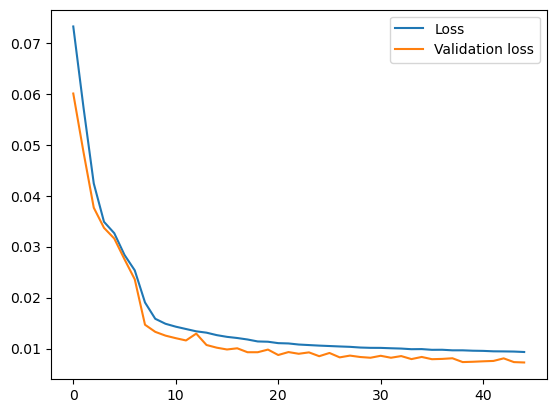

In [67]:
plt.plot(history.history["loss"][5:], label = "Loss")
plt.plot(history.history["val_loss"][5:], label = "Validation loss")

plt.legend()
plt.show()

In [68]:
multi_lstm_model.save("models/MultiLSTM", save_format="h5")